In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from pathlib import Path
import os
import keras
plt.rc('figure',titleweight='bold',titlesize='large',figsize=(15,6))
plt.rc('axes',titleweight='bold',titlesize='large',labelweight='bold',labelsize='large',grid=True)

2024-09-20 20:03:23.942773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 20:03:23.953291: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 20:03:23.956710: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 20:03:23.965086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 20:03:24.667553: W tensorflow/compiler/tf2

In [2]:
x=np.arange(0,10,0.01)
wave=np.sin(5*x)+np.sin(10*x)+x

n_input = 5
n_features = 1
x=[]
y=[]
for i in range(len(wave)-n_input-1):
    x.append(wave[i:i+n_input].tolist())
    y.append(wave[i+n_input])
x,y=np.array(x),np.array(y)
x.shape,y.shape

((994, 5), (994,))

Text(0.5, 1.0, 'Data')

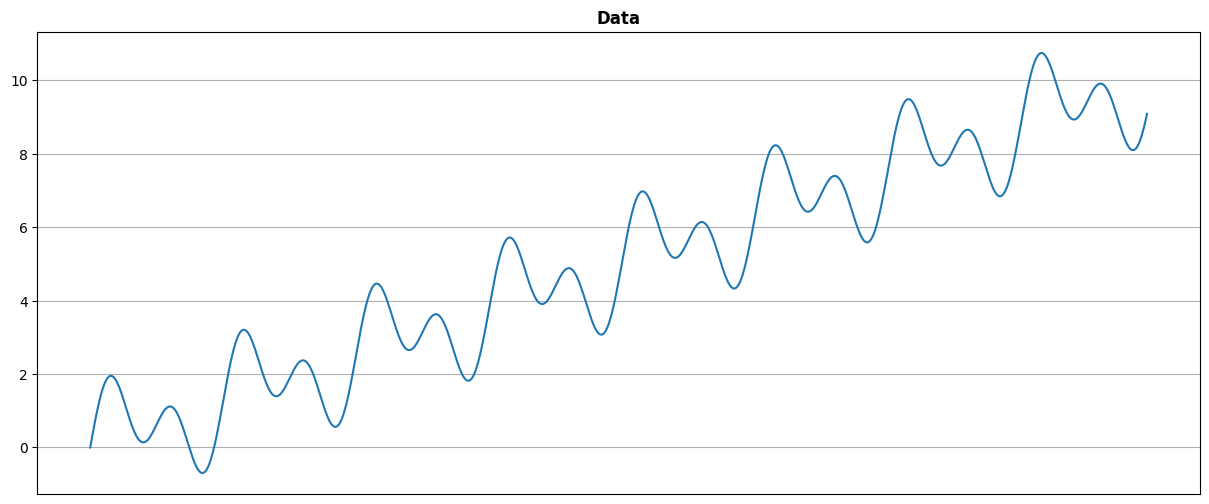

In [3]:
fg=plt.figure()
ax=fg.add_subplot()
ax.plot(wave)
ax.set_xticks([],[])
ax.set_title('Data')

In [4]:
def positional_encoding(sequence_len, embedding_dim, n=10000):
    p=np.zeros((sequence_len, embedding_dim))
    for k in range(sequence_len):
        for i in np.arange(embedding_dim//2):
            denominator=np.power(n, 2*i/embedding_dim)
            p[k, 2*i]=np.sin(k/denominator)
            p[k, 2*i+1]=np.cos(k/denominator)
    return p

In [5]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score=tf.matmul(query, key,transpose_b=True)
        dim_key=key.shape[-1]
        score/=np.sqrt(dim_key)
        weights=keras.ops.softmax(score, axis=-1)
        output=tf.matmul(weights, value)
        return output

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value = inputs
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention = self.attention(query, key, value)

        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        output = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(output)
        return output

In [6]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.att = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1=layers.LayerNormalization()
        self.layernorm2=layers.LayerNormalization()
        self.dropout1=layers.Dropout(0.1)
        self.dropout2=layers.Dropout(0.1)

    def call(self, inputs):
        attn_output = self.att([inputs, inputs, inputs])
        out1 = self.layernorm1(inputs + attn_output) #residual connection
        ffn_output = self.ffn(out1)
        out2=self.layernorm2(out1 + ffn_output) # residual connection
        return out2

In [7]:
def build_transformer_model(input_shape, num_heads, embed_dim, ff_dim):
    inputs = layers.Input(shape=input_shape)
    pos_enc = positional_encoding(input_shape[0], embed_dim)
    x = inputs + pos_enc

    transformer_block=TransformerBlock(embed_dim, num_heads, ff_dim)
    x=transformer_block(x)
    x=layers.Dense(20, activation="relu")(x)
    x=layers.Flatten()(x)
    outputs = layers.Dense(1)(x)

    model=tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [8]:
input_shape = (n_input, n_features)
num_heads = 8
embed_dim = 512
ff_dim = 64

model = build_transformer_model(input_shape, num_heads, embed_dim, ff_dim)
model.compile(optimizer="adam", loss="mse")

best_lost=keras.callbacks.ModelCheckpoint(filepath=os.path.join(Path().cwd(),'transformers.keras'),monitor='loss',mode='min',save_best_only=True)
model.fit(x,y, epochs=15,batch_size=32,callbacks=[best_lost])

predictions = model.predict(x)

plt.plot(wave[n_input:], label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.show()

2024-09-20 20:03:26.333505: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/15


/py_virtual/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


12/32 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - loss: 16.1150